In [1]:
import mlx.core as mx
import mlx.nn as nn
import numpy as np
from mlx.data import datasets
from datasets_utils import cifar100

In [2]:
def get_streamed_data(data, batch_size=0, shuffled=True):
    def transform_image(x):
        return x.astype("float32") / 255.0

    buffer = data.shuffle() if shuffled else data
    stream = buffer.to_stream()
    stream = stream.key_transform("image", transform_image)
    stream = stream.batch(batch_size) if batch_size > 0 else stream
    return stream.prefetch(4, 2)

In [3]:
train_data = datasets.load_cifar100(train=True)
test_data = datasets.load_cifar100(train=False)

len(train_data), len(test_data)

(50000, 10000)

In [4]:
import time
np.random.seed(int(time.time()))
mx.random.seed(int(time.time()))

batch = get_streamed_data(train_data, batch_size=1, shuffled=False)
row = next(batch)
row["image"].shape, row["label"]

((1, 32, 32, 3), array([19]))

In [5]:
image = mx.array(row["image"])
label = mx.array(row["label"])

In [6]:
class ResidualBlock(nn.Module):
    """
    Implemented with an assumption that the dimensions does not increase from one residual
    block to the other.
    """
    def __init__(self, in_dims, dims, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_dims, dims, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm(dims)
        self.conv2 = nn.Conv2d(
            dims, dims, kernel_size=3, stride=1, padding=1, bias=False,
        )
        self.bn2 = nn.BatchNorm(dims)
        
    def __call__(self, x):
        out = nn.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + x
        out = nn.relu(out)

        return out

class ConvolutionBlock(nn.Module):
    def __init__(self, in_dims, dims, padding=1, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_dims, dims, kernel_size=3, padding=padding, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm(dims)
        self.conv2 = nn.Conv2d(dims, dims, kernel_size=3, padding=padding, stride=stride, bias=False)
        self.bn2 = nn.BatchNorm(dims)
    
    def __call__(self, x):
        out = nn.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = nn.relu(out)
        return out

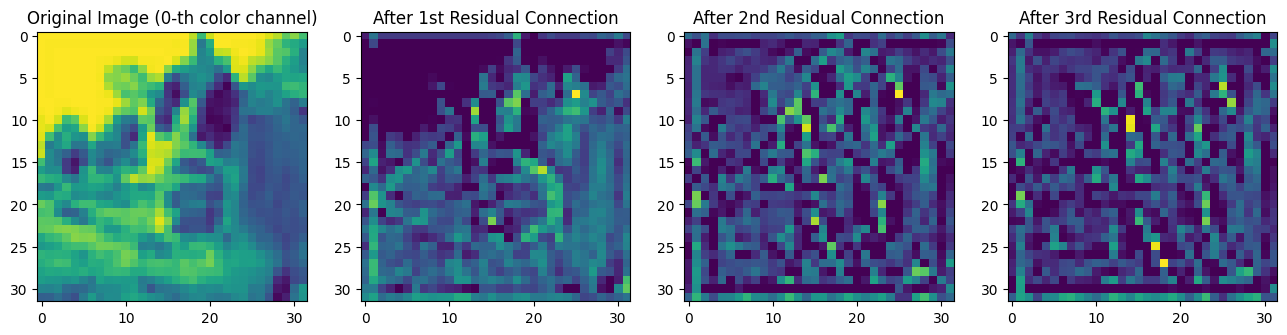

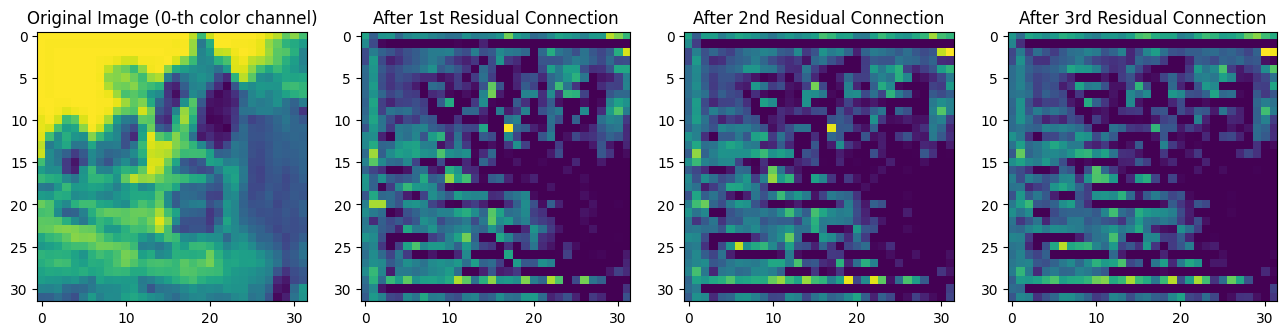

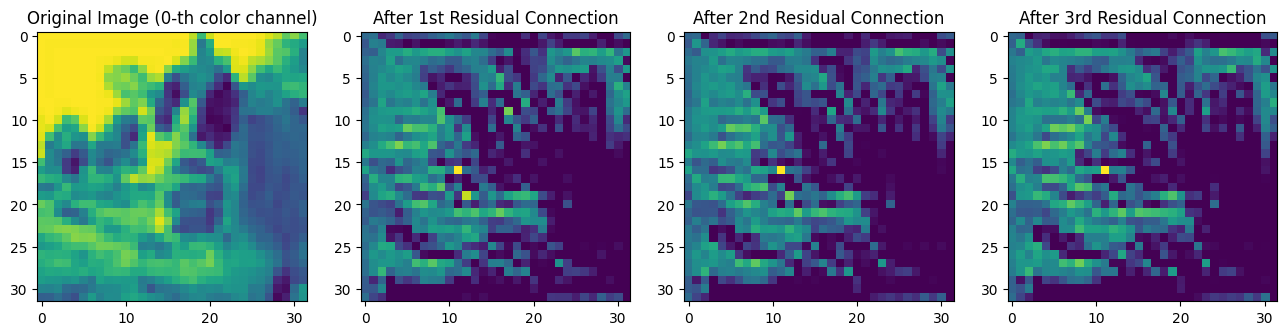

In [7]:
import matplotlib.pyplot as plt

in_dims = 3
out_dims = 3
n_cols = out_dims + 1
n_rows = 1
block = ResidualBlock(in_dims, out_dims)
y = block(image)

for i in range(out_dims):
    fig = plt.figure(figsize=(n_cols * 4, n_rows * 4))
    ax = fig.add_subplot(n_rows, n_cols, 1)
    ax.imshow(np.array(image)[0, :, :, 0])
    ax.set_title("Original Image (0-th color channel)")

    ax = fig.add_subplot(n_rows, n_cols, 2)
    ax.imshow(np.array(y)[0, :, :, i])
    ax.set_title("After 1st Residual Connection")

    y = block(y)
    ax = fig.add_subplot(n_rows, n_cols, 3)
    ax.imshow(np.array(y)[0, :, :, i])
    ax.set_title("After 2nd Residual Connection")

    y = block(y)
    ax = fig.add_subplot(n_rows, n_cols, 4)
    ax.imshow(np.array(y)[0, :, :, i])
    ax.set_title("After 3rd Residual Connection")

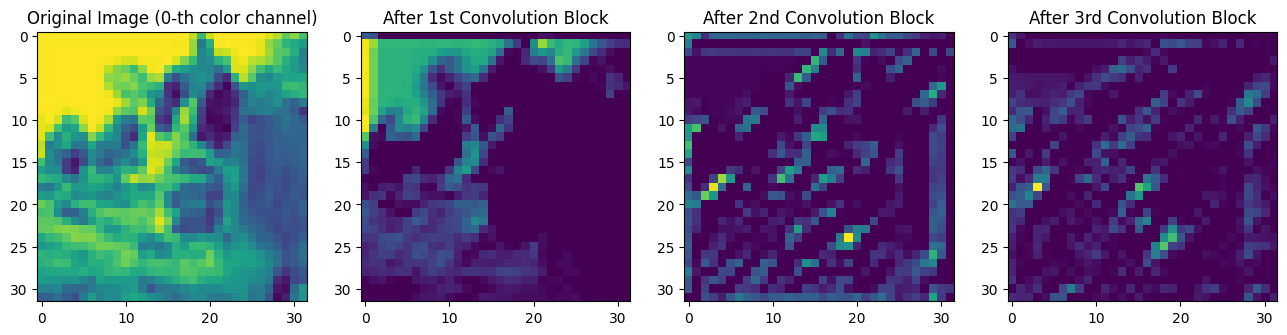

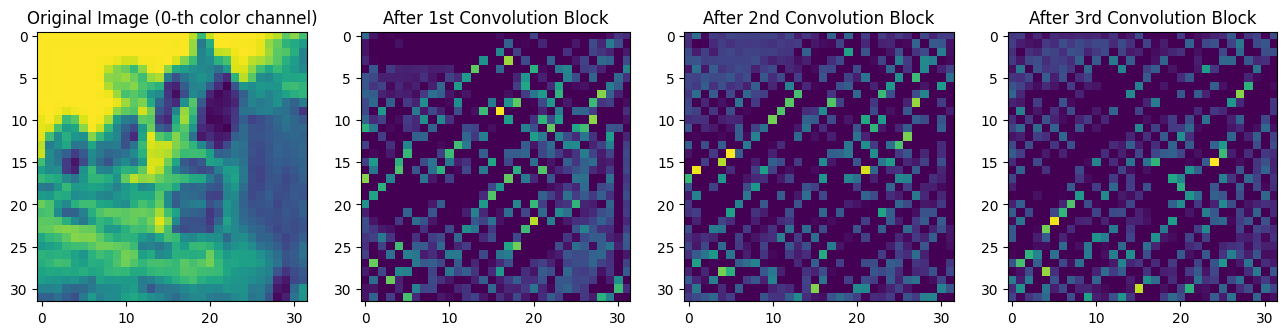

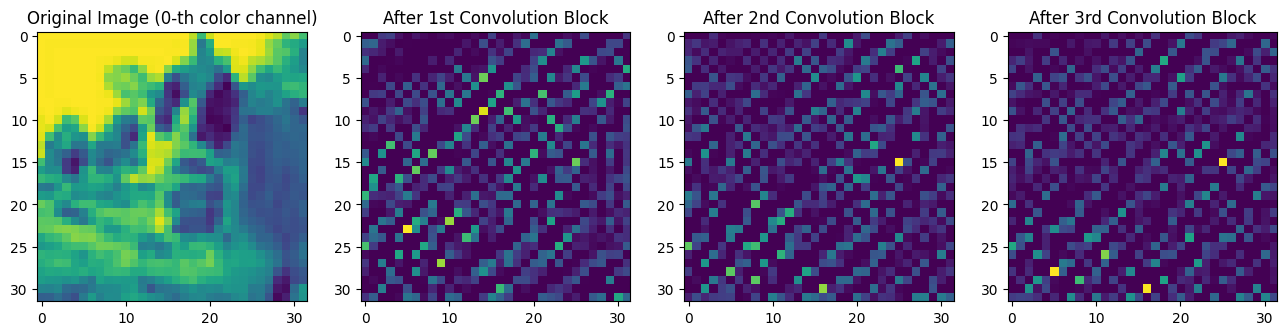

In [8]:
n_cols = 4
n_rows = 1

block = ConvolutionBlock(3, 3)
y = block(image)

for i in range(3):
    fig = plt.figure(figsize=(n_cols * 4, n_rows * 4))
    ax = fig.add_subplot(n_rows, n_cols, 1)
    ax.imshow(np.array(image)[0, :, :, 0])
    ax.set_title("Original Image (0-th color channel)")

    ax = fig.add_subplot(n_rows, n_cols, 2)
    ax.imshow(np.array(y)[0, :, :, i])
    ax.set_title("After 1st Convolution Block")

    y = block(y)
    ax = fig.add_subplot(n_rows, n_cols, 3)
    ax.imshow(np.array(y)[0, :, :, i])
    ax.set_title("After 2nd Convolution Block")

    y = block(y)
    ax = fig.add_subplot(n_rows, n_cols, 4)
    ax.imshow(np.array(y)[0, :, :, i])
    ax.set_title("After 3rd Convolution Block")